In [1]:
from src.tree_sitter_AST_utils import Tree_Sitter_ENFA, sub_str_from_coords, Node_Processor, Code_Parser, StringTSNode
import json
import networkx as nx
from IPython.display import Image, display
import autopep8
%load_ext autoreload
%autoreload 2

In [2]:
with open("src/tree-sitter/tree-sitter-python/src/grammar.json", "r") as grammar_file:
    python_grammar = json.load(grammar_file)

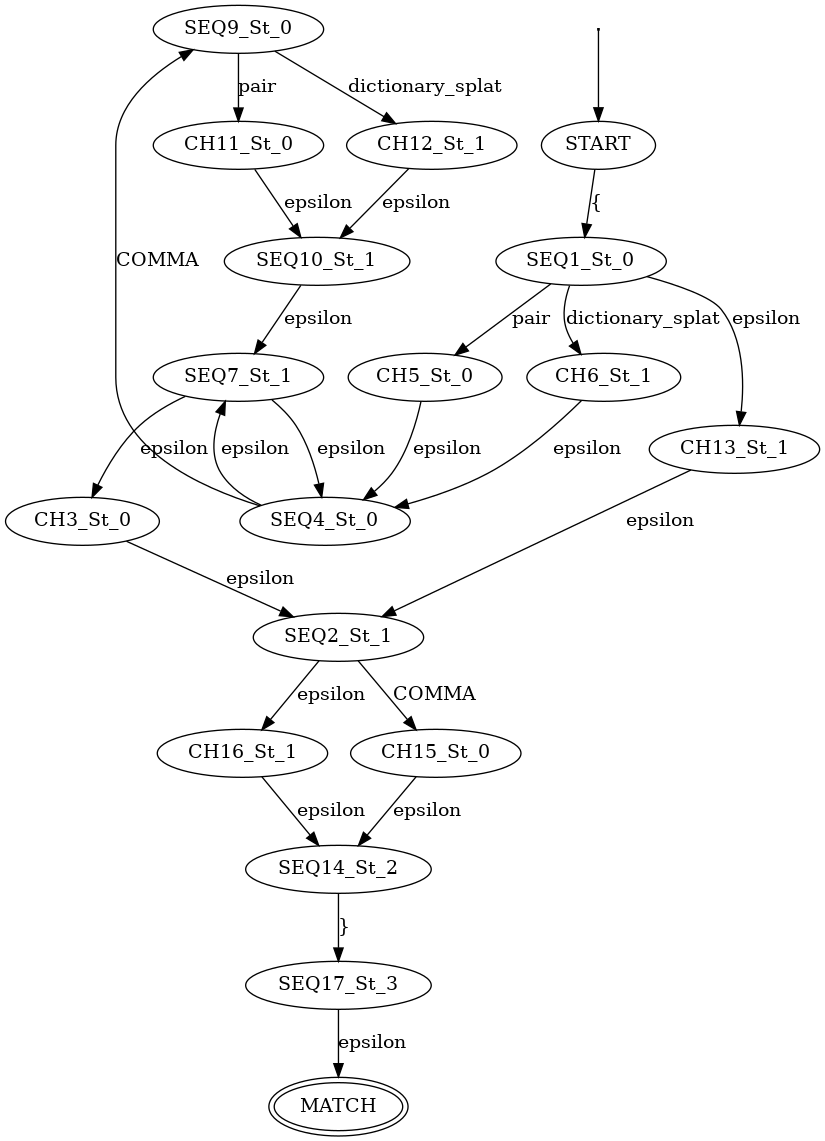

In [23]:
node_NFA = Tree_Sitter_ENFA("dictionary", python_grammar)
node_NFA.plot_dot()

## Pretty Printing a tree sitter parse tree

In [24]:
code_str = """
@property
def foo(a = 5):
    if (True):
        while 1==3:
            try:
                olive("bat").show
            except:
                print("fail")
        get_statement(a)

print("qux")
"""

In [25]:
python_parser = Code_Parser("python")
node_processor = Node_Processor()

In [26]:
code_tree = python_parser.parse_to_string_tree(code_str)

In [27]:
print(autopep8.fix_code(node_processor.to_string(code_tree)))

@ property
def foo(a=5):
    if (True):
        while 1 == 3:
            try:
                olive("bat")   . show
 except : 
                print ( "fail" )    
   
  
        get_statement ( a )    
  
  
 
print ( "qux" )    



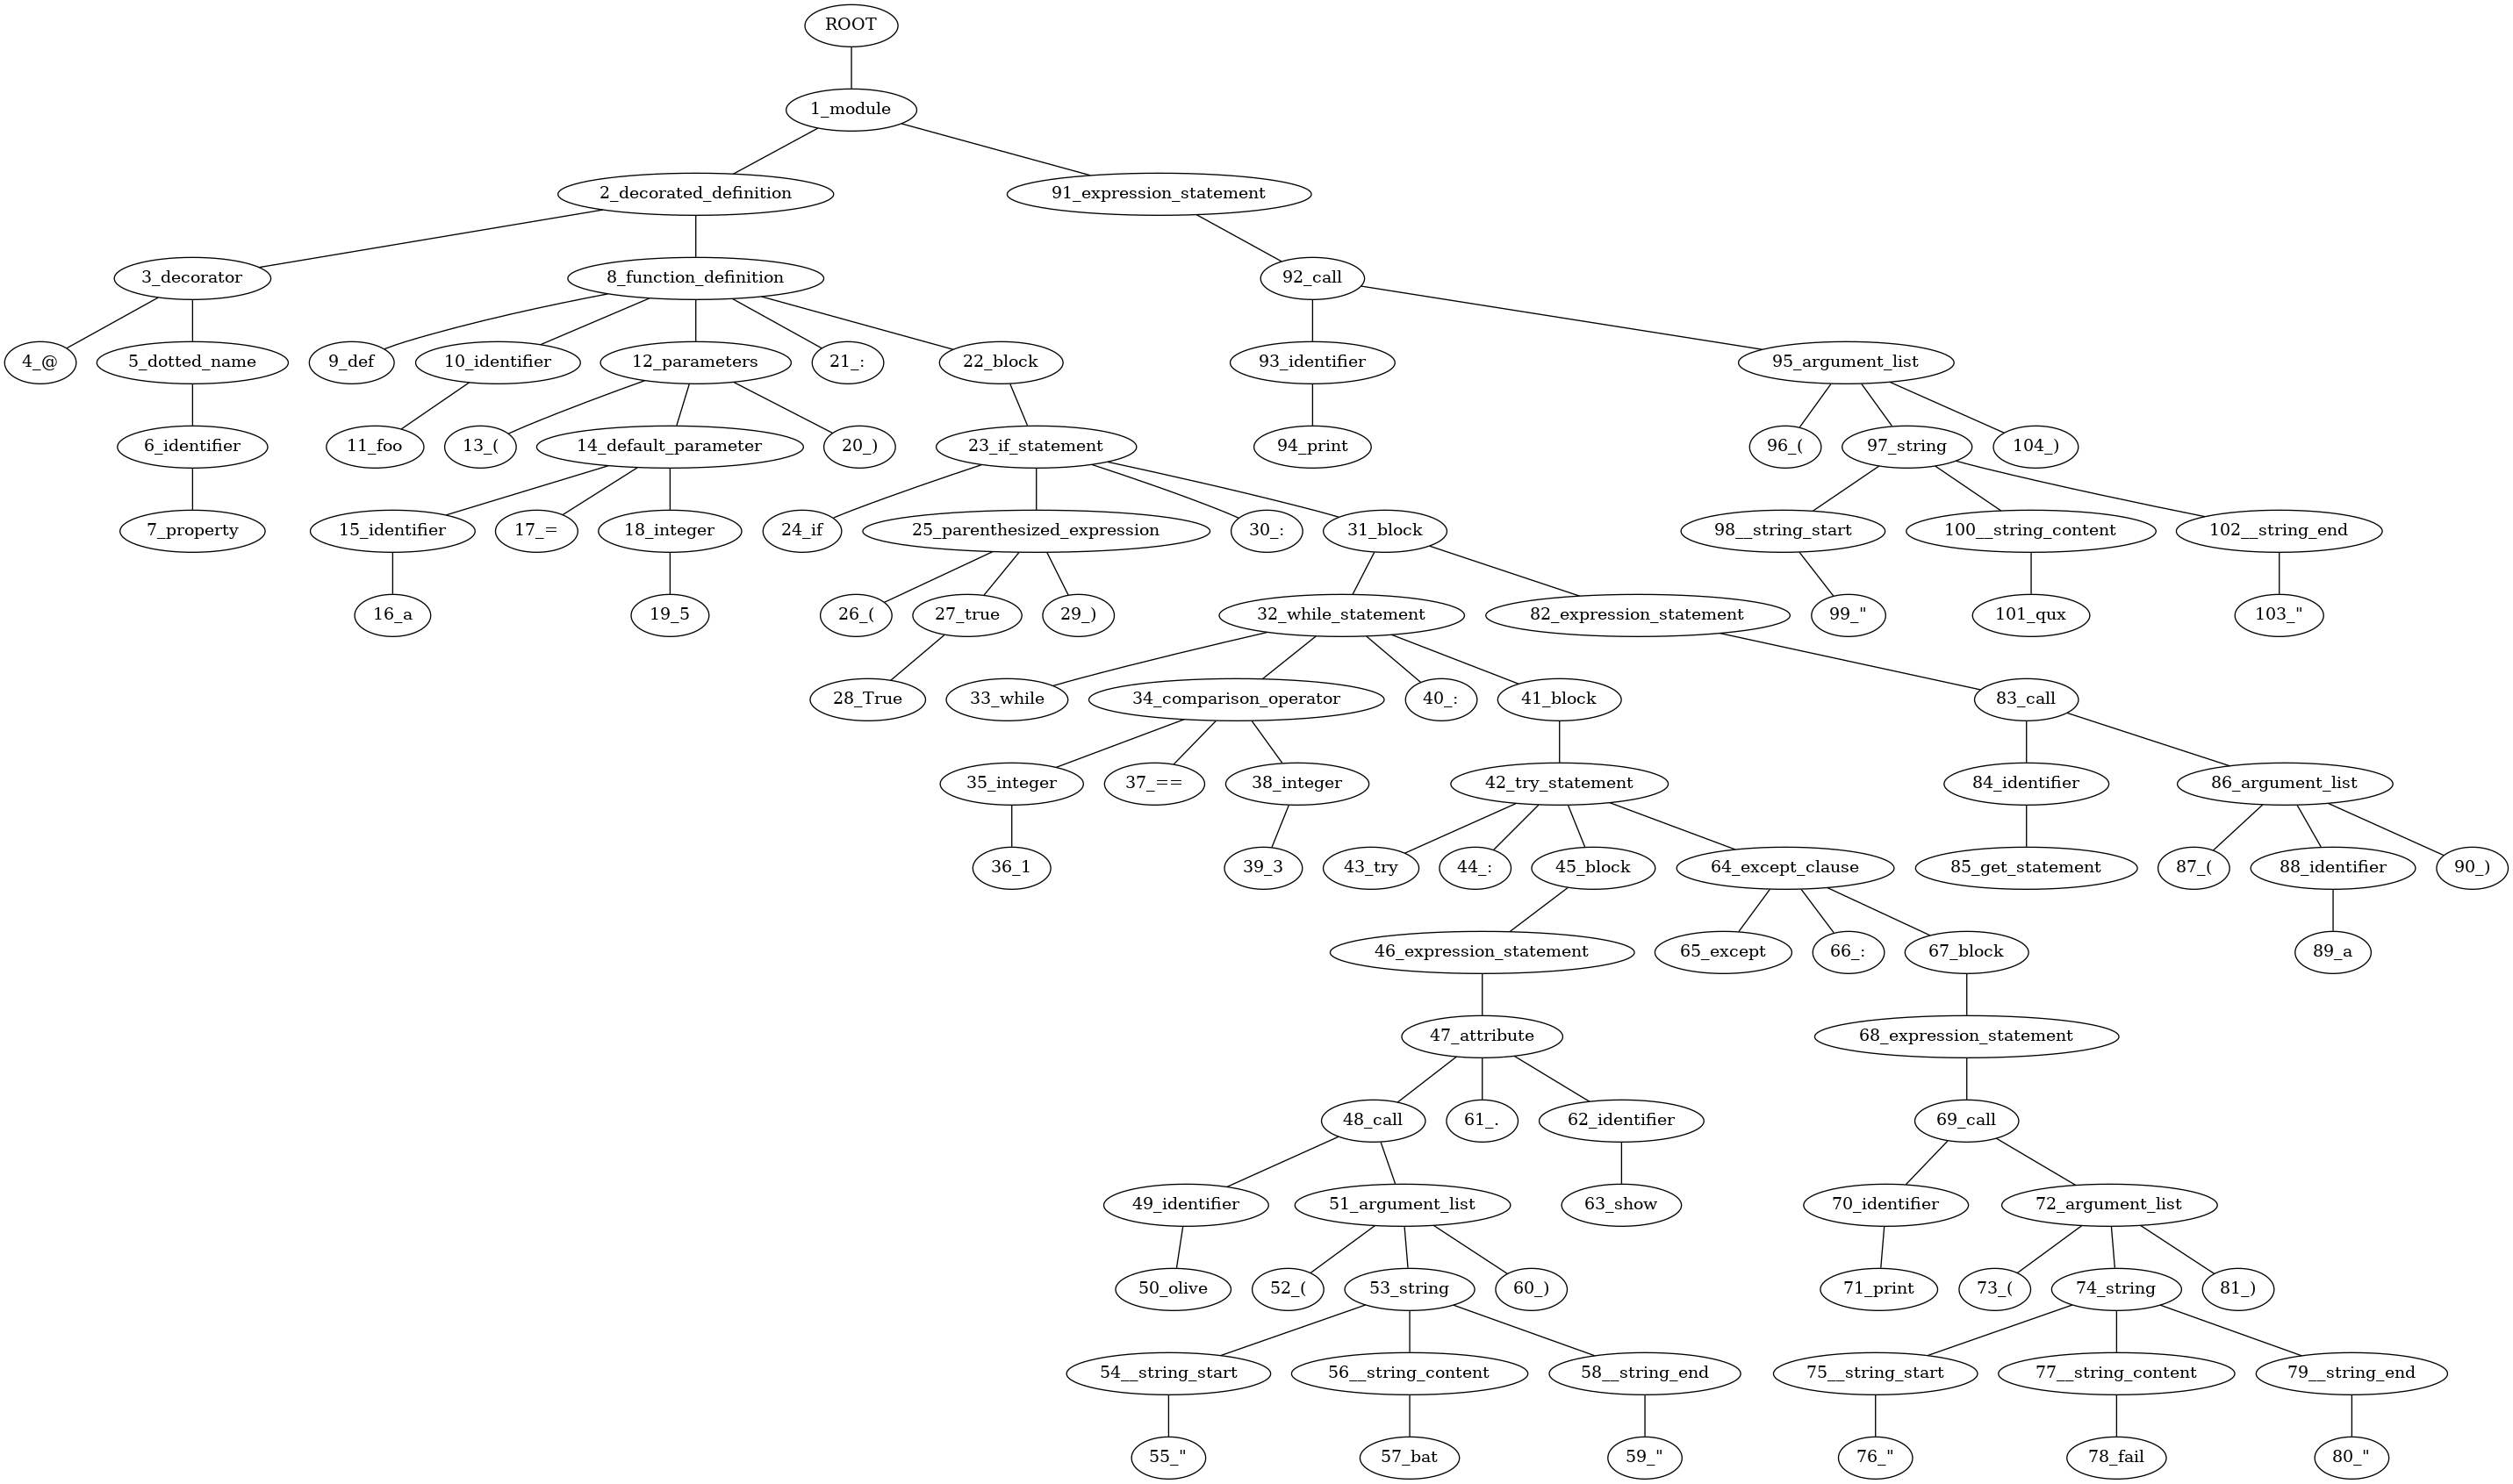

In [28]:
node_processor.plot(code_tree)

In [ ]:
BART("the moon <X> <\X> and I loved the walk") -> "was lovely"

In [ ]:
"module; expr; dict; {; <X> <\X>; }; REDUCE; REDUCE; REDUCE"